In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

     |████████████████████████████████| 235 kB 35.7 MB/s 
     |████████████████████████████████| 51 kB 3.4 MB/s 
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


Global seed set to 0


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 32.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


In [2]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

In [3]:
results_folder = './run_regression/result'

# create paths and names to results folders for reference regression and cell2location models
#ref_run_name = f'{results_folder}/reference_signatures'
#run_name = f'{results_folder}/cell2location_map'

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/st_decon/cell2location/run_regression/stride_data1"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['sc_count.csv',
 'sc_lable.csv',
 'obs.csv',
 'adata.csv',
 'run_regression',
 'scvi-tools']

In [5]:
import pandas as pd
#!pip install anndata
import anndata
import numpy as np
import itertools


In [6]:
# load simulated spatial data
# every column is a spot of sc
adata = pd.read_csv('adata.csv',index_col=0)

# read the true cell numbers
# every column is a spot of sc
obs = pd.read_csv('obs.csv',index_col=0)
obs.columns = adata.index

# read the true UMI count
#obs_2 = pd.read_csv(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_1_umis.csv',index_col=0)
#obs_2.columns = ['nUMI_' + i  for i in obs_2.columns]

# create AnnData object
adata = anndata.AnnData(adata, obs=obs.T)
#adata.obs[obs_2.columns] = obs_2

# generate random positions
adata.obsm['X_spatial'] = np.array(list(itertools.product(np.arange(np.ceil(np.sqrt(adata.shape[0]))), 
                       np.arange(np.ceil(np.sqrt(adata.shape[0]))))))[0:adata.shape[0],:]

#design

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  from ipykernel import kernelapp as app


In [7]:
adata_vis=adata

In [ ]:
adata.var

""
RP11-34P13.3
FAM138A
OR4F5
RP11-34P13.7
RP11-34P13.8
...
AC233755.2
AC233755.1
AC240274.1
AC213203.1


In [8]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
#adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [9]:
adata_vis.var

,SYMBOL
RP11-34P13.3,RP11-34P13.3
FAM138A,FAM138A
OR4F5,OR4F5
RP11-34P13.7,RP11-34P13.7
RP11-34P13.8,RP11-34P13.8
...,...
AC233755.2,AC233755.2
AC233755.1,AC233755.1
AC240274.1,AC240274.1
AC213203.1,AC213203.1


In [9]:
adata_vis.obs['Sample']='sample'

downsample data

In [10]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
    
# remove MT genes for spatial mapping (keeping their counts in the object)
#adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
#adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [11]:
# load single cell reference used for simulation (validation set)
counts_validation = pd.read_csv('sc_count.csv',index_col=0)
#adata = pd.read_csv('adata.csv',index_col=0)
labels_validation = pd.read_csv('sc_lable.csv',index_col=0)
labels_validation.columns = counts_validation.index


In [12]:
labels_validation.index=['label']

In [13]:
adata_snrna_raw = anndata.AnnData(counts_validation, obs=labels_validation.T)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [14]:
adata_ref=adata_snrna_raw

In [15]:
adata_ref.obs['Sample']='sample'

In [ ]:
adata_ref

AnnData object with n_obs × n_vars = 4876 × 33694
    obs: 'label', 'Sample'

In [ ]:
adata_ref.var

""
RP11-34P13.3
FAM138A
OR4F5
RP11-34P13.7
RP11-34P13.8
...
AC233755.2
AC233755.1
AC240274.1
AC213203.1


In [16]:
adata_ref.var['SYMBOL'] = adata_ref.var.index 
# rename 'GeneID-2' as necessary for your data
#adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


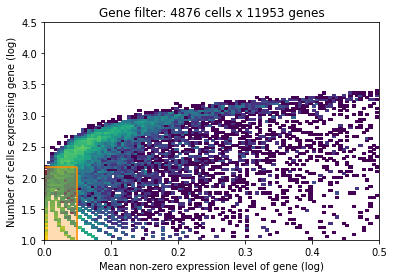

In [17]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [18]:
import cell2location

In [27]:
adata_ref.obs['Method']='5''

In [28]:
adata_ref.obs['label']

sc5rJUQ026_AAACCTGAGACGACGT    Cancer
sc5rJUQ026_AAACCTGCAATGGAGC    Cancer
sc5rJUQ026_AAACCTGCAGGCTGAA        EC
sc5rJUQ026_AAACCTGCATCTCGCT    T_cell
sc5rJUQ026_AAACCTGGTACTCAAC    Cancer
                                ...  
sc5rJUQ026_TTTGTCACATCGATTG    Cancer
sc5rJUQ026_TTTGTCAGTACAGTGG    Cancer
sc5rJUQ026_TTTGTCAGTGGTACAG    Cancer
sc5rJUQ026_TTTGTCATCTGGTTCC    Cancer
sc5rJUQ026_TTTGTCATCTTCGGTC    Cancer
Name: label, Length: 4876, dtype: object

In [29]:
adata_ref.obs_keys()

['label',
 'Sample',
 'Method',
 'Subset',
 '_indices',
 '_scvi_batch',
 '_scvi_labels']

In [23]:
adata_vis.var

,SYMBOL,MT_gene
RP11-34P13.3,RP11-34P13.3,False
FAM138A,FAM138A,False
OR4F5,OR4F5,False
RP11-34P13.7,RP11-34P13.7,False
RP11-34P13.8,RP11-34P13.8,False
...,...,...
AC233755.2,AC233755.2,False
AC233755.1,AC233755.1,False
AC240274.1,AC240274.1,False
AC213203.1,AC213203.1,False


In [30]:
adata_ref.obs['Subset']=adata_ref.obs['label']

In [31]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='Sample', 
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )

In [32]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 11953 │
│         n_cells          │ 4876  │
│         n_batch          │   1   │
│         n_labels         │   8   │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│         labels         │         adata.obs['_scvi_labels']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
└────────────────────────┴────────────────────────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │   sample   │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                  labels State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │   B_cell   │          0          │
│                     │   Cancer   │          1          │
│                     │     DC     │          2          │
│                     │     EC     │          3          │
│                     │ Fibroblast │          4          │
│                     │    Mast    │          5          │
│                     │  Myeloid   │          6          │
│                     │   T_cell   │          7          │
└─────────────────────┴────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │     5      │          0          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [33]:
mod.train(max_epochs=250, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 250/250: 100%|██████████| 250/250 [01:31<00:00,  2.73it/s, v_num=1, elbo_train=1.99e+7]


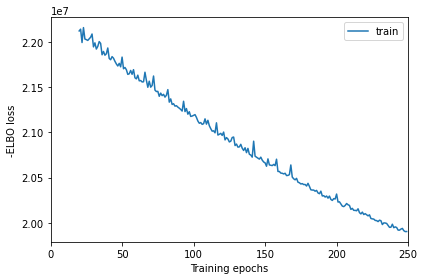

In [ ]:
mod.plot_history(20)

In [34]:
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [ ]:
ref_run_name

'./run_regression/result/reference_signatures'

In [36]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)





Sampling global variables, sample: 100%|██████████| 999/999 [00:19<00:00, 50.48it/s]


In [37]:
# Save model
mod.save(f"{ref_run_name}", overwrite=True)

In [38]:
#adata_ref.obs.tostring
# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'./run_regression/result/reference_signatures/sc.h5ad'

In [39]:
adata_ref.obs_keys()

['label',
 'Sample',
 'Method',
 'Subset',
 '_indices',
 '_scvi_batch',
 '_scvi_labels']

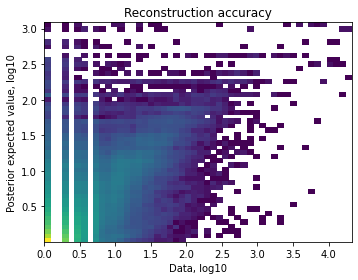

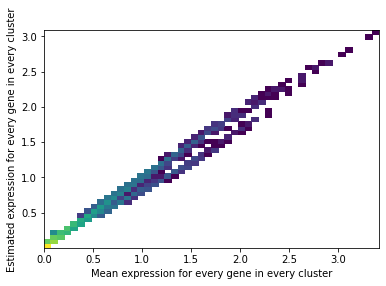

In [40]:
mod.plot_QC()


In [ ]:
adata_ref

AnnData object with n_obs × n_vars = 4876 × 11953
    obs: '_indices'

In [41]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./run_regression/result/reference_signatures/model.pt already downloaded                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s, v_num=1, elbo_train=1.9e+7]


In [42]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_cell,Cancer,DC,EC,Fibroblast
FO538757.2,0.149486,0.121994,0.503980,0.155569,0.149875
AP006222.2,0.059726,0.004227,0.000282,0.038317,0.080893
RP11-54O7.3,0.000281,0.004821,0.000282,0.000280,0.000277
NOC2L,0.384619,0.071193,1.067127,0.129526,0.185999
RP11-54O7.17,0.000278,0.001202,0.000280,0.024289,0.003680


In [43]:
adata_vis.obs["sample"]='sample'

In [44]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [45]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=8,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
) 
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.1.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 11953 │
│         n_cells          │ 1000  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │   sample   │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 30000/30000: 100%|██████████| 30000/30000 [50:28<00:00,  9.91it/s, v_num=1, elbo_train=9.19e+6]


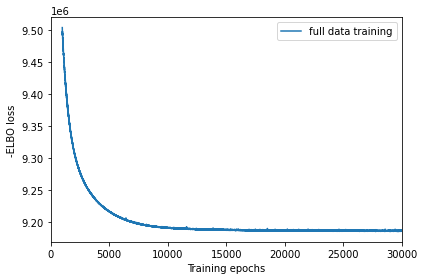

In [46]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [47]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:23<00:00, 43.16it/s]


'./run_regression/result/cell2location_map/sp.h5ad'

In [ ]:
run_name

'./run_regression/result/cell2location_map'

In [49]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./run_regression/result/cell2location_map/sp.h5ad'

In [50]:
adata_file = f"{run_name}/ap3.csv"
adata_vis.obsm['q95_cell_abundance_w_sf'].to_csv(adata_file)

In [51]:
adata_vis.obsm

AxisArrays with keys: X_spatial, means_cell_abundance_w_sf, stds_cell_abundance_w_sf, q05_cell_abundance_w_sf, q95_cell_abundance_w_sf

In [53]:
adata_file = f"{run_name}/ap1.csv"
adata_vis.obsm['means_cell_abundance_w_sf'].to_csv(adata_file)

stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'